In [91]:
#pip install mca

In [22]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import mca
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [125]:
CDG = pd.read_csv("./Stations/CDG.csv")
SL = pd.read_csv("./Stations/SL.csv")
SGP = pd.read_csv("./Stations/SGP.csv")
BL = pd.read_csv("./Stations/BL.csv")

metro = pd.concat([CDG, SL, SGP, BL], ignore_index=True)

# Cleaning again

In [128]:
metro['real_arrival'] = pd.to_datetime(metro['real_arrival'], format='%Y-%m-%d %H:%M:%S')
metro['real_departure'] = pd.to_datetime(metro['real_departure'], format='%Y-%m-%d %H:%M:%S')

metro = metro.sort_values(by='stop_name', ascending=False)
metro['stop_name'] = pd.factorize(metro["stop_name"])[0]
metro['destination_name'] = pd.factorize(metro["destination_name"])[0]

metro = metro.sort_values(by='real_arrival', ascending=True)

metro["departure_status"] = metro["departure_status"].astype("string")
metro["is_day"] = metro["is_day"].astype(int)

In [130]:
metro['pourc_validations'] = metro['pourc_validations'].fillna(0)

In [132]:
metro = metro.drop(["real_departure", "ArRTown", "Date", "day_type", "is_bank_holiday", "is_weekend"], axis=1)

In [134]:
metro_learn = metro
metro_test = metro

start_date = pd.to_datetime('2024-11-02 00:00:00')
end_date = pd.to_datetime('2025-01-12 23:59:59')

start_date2 = pd.to_datetime('2025-01-13 00:00:00')
end_date2 = pd.to_datetime('2025-01-19 23:59:59')

metro_learn = metro_learn[(metro_learn['real_arrival'] >= start_date) & (metro_learn['real_arrival'] <= end_date)]
metro_test = metro_test[(metro_test['real_arrival'] >= start_date2) & (metro_test['real_arrival'] <= end_date2)]


# PCA

In [99]:
# Select numerical variables
numerical_vars = metro_learn.select_dtypes(include=['float64'])

# Standardize the numerical variables
scaler = StandardScaler()
numerical_vars_scaled = scaler.fit_transform(numerical_vars)

# Perform PCA
pca = PCA()
pca_results = pca.fit_transform(numerical_vars_scaled)

In [100]:
# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(
    pca_results,
    columns=[f'PC{i+1}' for i in range(pca_results.shape[1])]
)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Output the PCA results and explained variance
print("Explained Variance Ratio:", explained_variance)
print("PCA DataFrame Head:\n", pca_df.head())

Explained Variance Ratio: [0.21908206 0.20253167 0.13646011 0.10119626 0.09166042 0.07705596
 0.05998427 0.04629283 0.0386112  0.01986902 0.00362224 0.0027163
 0.00091768]
PCA DataFrame Head:
         PC1       PC2       PC3       PC4       PC5       PC6      PC7  \
0 -3.244942  0.710312  1.118166  0.622022  1.313204  0.404264  5.24607   
1 -3.244942  0.710312  1.118166  0.622022  1.313204  0.404264  5.24607   
2 -3.244942  0.710312  1.118166  0.622022  1.313204  0.404264  5.24607   
3 -3.244942  0.710312  1.118166  0.622022  1.313204  0.404264  5.24607   
4 -3.244942  0.710312  1.118166  0.622022  1.313204  0.404264  5.24607   

        PC8       PC9      PC10      PC11      PC12      PC13  
0  0.242501  0.137819 -0.312697  0.104065 -0.023492  0.004076  
1  0.242501  0.137819 -0.312697  0.104065 -0.023492  0.004076  
2  0.242501  0.137819 -0.312697  0.104065 -0.023492  0.004076  
3  0.242501  0.137819 -0.312697  0.104065 -0.023492  0.004076  
4  0.242501  0.137819 -0.312697  0.104065 

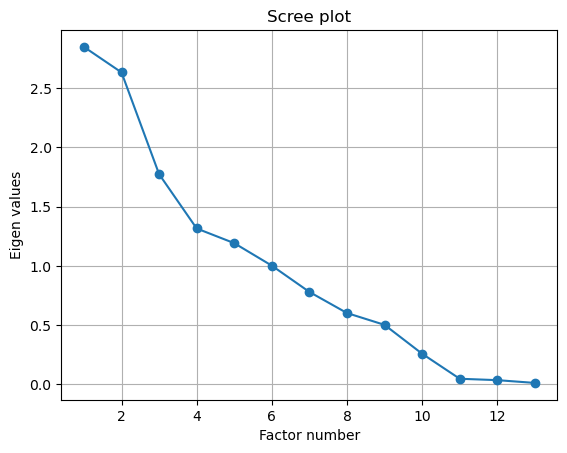

In [101]:
# -or
# Assuming you already have your dataset loaded into 'APK' DataFrame and it's preprocessed

# Select numerical columns
numerical_vars = metro_learn.select_dtypes(include=['float64'])

# Standardize the data
scaler = StandardScaler()
numerical_vars_scaled = scaler.fit_transform(numerical_vars)

# Perform PCA
pca = PCA()
pca.fit(numerical_vars_scaled)

# Eigenvalues (explained variance for each principal component)
eigval = pca.explained_variance_

# Number of components (k)
k = len(eigval)

# Scree plot
plt.plot(np.arange(1, k + 1), eigval, marker='o')
plt.title("Scree plot")
plt.ylabel("Eigen values")
plt.xlabel("Factor number")
plt.grid(True)
plt.savefig('Screeplot.png', bbox_inches='tight', dpi=300)
plt.show()


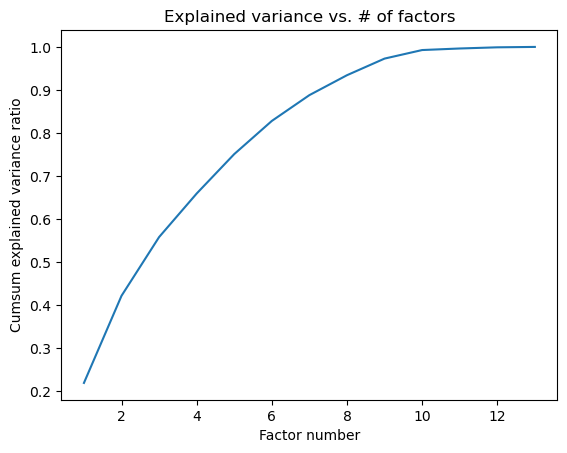

In [102]:
plt.plot(np.arange(1,k+1),np.cumsum(pca.explained_variance_ratio_)) 
plt.title("Explained variance vs. # of factors") 
plt.ylabel("Cumsum explained variance ratio") 
plt.xlabel("Factor number") 
plt.savefig('CumSumPlot.png', bbox_inches='tight', dpi=300)
plt.show()

In [103]:
## 5 factors picked for expainability

In [104]:
eigval

array([2.84857033, 2.63337716, 1.77429506, 1.31578393, 1.19179613,
       1.00190453, 0.77993341, 0.60191314, 0.50203439, 0.25834288,
       0.04709748, 0.03531811, 0.01193191])

In [105]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.21908206 0.42161373 0.55807383 0.65927009 0.75093051 0.82798647
 0.88797074 0.93426356 0.97287477 0.99274378 0.99636603 0.99908232
 1.        ]


# MCA - to do

# Random Forest

In [136]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)  #% of missing values
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #create result table
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

print(missing_values_table(metro)) 

There are 0 columns that have missing values.
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


### include standardised float cols - unfinished

# prediction

In [138]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [140]:
#APK_learn = APK_learn.drop(["scheduled_arrival"], axis=1)
#APK_learn["scheduled_arrival"] = APK_learn["scheduled_arrival"].astype(object)
# Convert datetime to numeric timestamp
#APK_learn['scheduled_arrival_numeric'] = APK_learn['scheduled_arrival'].apply(lambda x: x.timestamp())

In [142]:
metro_learn = metro_learn.copy()
metro_learn.loc[:, 'real_arrival' + '_year'] = metro_learn['real_arrival'].dt.year
metro_learn.loc[:, 'real_arrival' + '_month'] = metro_learn['real_arrival'].dt.month
metro_learn.loc[:, 'real_arrival' + '_day'] = metro_learn['real_arrival'].dt.day
metro_learn.loc[:, 'real_arrival' + '_hour'] = metro_learn['real_arrival'].dt.hour
metro_learn.loc[:, 'real_arrival' + '_minute'] = metro_learn['real_arrival'].dt.minute
metro_learn.loc[:, 'real_arrival' + '_second'] = metro_learn['real_arrival'].dt.second

metro_test = metro_test.copy()
metro_test.loc[:, 'real_arrival' + '_year'] = metro_test['real_arrival'].dt.year
metro_test.loc[:, 'real_arrival' + '_month'] = metro_test['real_arrival'].dt.month
metro_test.loc[:, 'real_arrival' + '_day'] = metro_test['real_arrival'].dt.day
metro_test.loc[:, 'real_arrival' + '_hour'] = metro_test['real_arrival'].dt.hour
metro_test.loc[:, 'real_arrival' + '_minute'] = metro_test['real_arrival'].dt.minute
metro_test.loc[:, 'real_arrival' + '_second'] = metro_test['real_arrival'].dt.second

In [144]:
metro_learn.drop(['real_arrival'], axis=1, inplace=True)  # Drop the original datetime column if not needed
metro_test.drop(['real_arrival'], axis=1, inplace=True)  # Drop the original datetime column if not needed

In [146]:
#APK_learn = APK_learn[['scheduled_arrival_numeric'] + [col for col in APK_learn.columns if col != 'scheduled_arrival_numeric']]

In [148]:
# Assuming APK_learn is your DataFrame
# Extract the explanatory variables and the target variable
metro_learn_X = metro_learn.drop('departure_status', axis=1)  # Features (exclude target)
metro_learn_Y = metro_learn['departure_status']  # Target variable

# Train-test split (80-20 split)
X_train, X_test, Y_train, Y_test = train_test_split(metro_learn_X, 
                                                    metro_learn_Y, 
                                                    test_size=0.2, 
                                                    random_state=42)


In [150]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid for GridSearchCV
rf_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [152]:
# Perform GridSearchCV with StratifiedKFold cross-validation
cv_folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
rf_cv = GridSearchCV(rf, rf_grid, cv=cv_folds, n_jobs=-1, scoring='accuracy')

In [154]:
rf_cv.fit(X_train, Y_train)

# Output the best hyperparameters found by GridSearchCV
print(f"Best hyperparameters: {rf_cv.best_params_}")

Best hyperparameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


In [155]:
metro_test_X = metro_test.drop('departure_status', axis=1)  # Features (exclude target)
metro_test_Y = metro_test['departure_status']  # Target variable


In [156]:
# Evaluate the model on the test set
best_model = rf_cv.best_estimator_

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(metro_test_X)

# Print the accuracy on training and test sets
print(f"Training Accuracy: {accuracy_score(Y_train, y_pred_train):.4f}")
print(f"Test Accuracy: {accuracy_score(metro_test_Y, y_pred_test):.4f}")

# Create DataFrames for plotting prediction vs true values
train_pred_vs_true = pd.DataFrame({'True': Y_train, 
                                   'Predicted': y_pred_train})

test_pred_vs_true = pd.DataFrame({'True': metro_test_Y, 
                                  'Predicted': y_pred_test})

Training Accuracy: 0.9990
Test Accuracy: 0.9943


In [157]:
# Assuming 'PRIMARY_KEY' is a column in your test set
# Create a DataFrame with PRIMARY_KEY and predicted target values
predictions_df = pd.DataFrame({
    'datetime': metro_test_X[['real_arrival_year', 'real_arrival_month', 'real_arrival_day', 
                           'real_arrival_hour', 'real_arrival_minute', 'real_arrival_second']].apply(
                            lambda row: '-'.join(row.astype(str)), axis=1),  # Combine as a single key
    'target': y_pred_test
})


# Save the predictions to a CSV file
#predictions_df.to_csv('sigh.csv', index=False, sep=',', float_format='%.6f')  # Save with US decimal notation


In [158]:
#metro_pred = pd.read_csv("sigh.csv")

In [159]:
# Generate confusion matrix
conf_matrix = confusion_matrix(metro_test_Y, y_pred_test)
print(conf_matrix)


[[  42   26]
 [   6 5515]]


In [160]:
metro_test['departure_status'].value_counts()

departure_status
onTime     5521
delayed      68
Name: count, dtype: Int64